# Periodic Driving
In this example we want to efficiently implement a Spin Echo pulse using periodic driving by making use of the concatenation property of filter functions. We assume a control Hamiltonian of the form

$$
    {H}_c = \frac{\omega_0}{2}\sigma_z + A\sin(\omega_\mathrm{d}t + \phi)\sigma_x
$$

and compute the filter function for a single period of the drive:

In [1]:
import time

import numpy as np
import qutip as qt

import filter_functions as ff

In [2]:
# We calculate with hbar == 1
Delta = 0.0   # set detuning to zero
omega_d = 20e9*2*np.pi
omega_0 = omega_d + Delta
# Phase shift; phi = 0 gives us a rotation about Y, phi = pi/2 about X
phi = np.pi/2
# Rabi frequency
Omega_R = 1e6*2*np.pi
A = np.sqrt(Omega_R**2 - Delta**2)
T = 2*np.pi/omega_d

t = np.linspace(0, T, 21)
dt = np.diff(t)
# Paulis
X, Y, Z = ff.util.paulis[1:]

H_c = [[Z, [omega_0/2]*len(dt), 'Z'],
       [X, A*np.sin(omega_d*t[1:] + phi), 'X']]
H_n = [[Z, np.ones_like(dt), 'Z'],
       [X, np.ones_like(dt), 'X']]

# Track the performance of the individual steps
tic = []
toc = []

tic.append(time.perf_counter())
X_ATOMIC = ff.PulseSequence(H_c, H_n, dt)
toc.append(time.perf_counter())

# We have to set the frequencies now, and since we plan to make a much longer
# sequence than just a single period, we choose a much lower infrared cutoff 
# than we would for the single period.
omega = np.geomspace(1e-10*omega_0, 1e2*omega_0, 500)

# Cache the filter function for a single period of the drive to be able to
# reuse it later.
tic.append(time.perf_counter())
X_ATOMIC.cache_filter_function(omega)
toc.append(time.perf_counter())

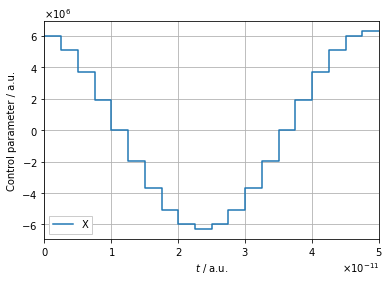

In [3]:
# Plot the pulse train for the drive only
from filter_functions import plotting

_ = plotting.plot_pulse_train(X_ATOMIC, c_oper_identifiers=['X'])

## Concatenating filter functions
In order to achieve a rotation by $\pi$ about the $x$-axis, we need to pulse for $t = \frac{\omega_\mathrm{d}}{2\Omega_R }T$, that is, repeat `X_ATOMIC` 10000 times:

In [4]:
from itertools import repeat

tic.append(time.perf_counter())
NOT_PERIODIC = ff.concatenate_periodic(X_ATOMIC, 10000)
toc.append(time.perf_counter())

tic.append(time.perf_counter())
NOT_STANDARD = ff.concatenate(repeat(X_ATOMIC, 10000))
toc.append(time.perf_counter())

We can check if the concatenated pulse actually does what we intended it to do by computing the overlap with the target propagator $U_t = \sigma_x$ via the Hilbert-Schmidt inner product,

$$
    \frac{1}{d}\left|\langle Q, U_t\rangle_\mathrm{HS}\right| = \frac{1}{d}\left|\mathrm{tr}\!\left(Q^\dagger U_t\right)\right|,
$$

where we take the absolute value since a global phase is of no interest.

0.98766778476173


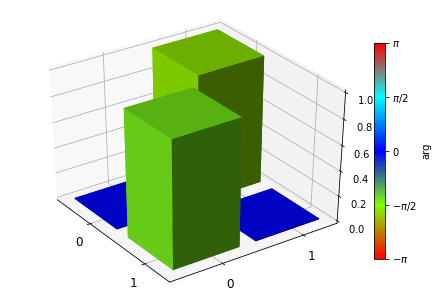

In [5]:
# Overlap between the target and actual propagators
print(abs(ff.util.dot_HS(NOT_PERIODIC.total_Q, qt.sigmax()))/2)
# Plot the total propagator of NOT
_ = qt.matrix_histogram_complex(NOT_PERIODIC.total_Q)

Finally, we sandwich the $\pi$-pulse between two periods of free evolution to get the filter function for the SE:

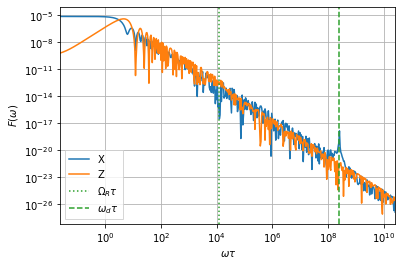

In [6]:
# Since we do not apply any control, we can just use one very long time step
dt = [1e-3]  # 1 ms
H_c = [[X, [0], 'X']]
H_n = [[Z, np.ones_like(dt), 'Z'],
       [X, np.ones_like(dt), 'X']]

WAIT = ff.PulseSequence(H_c, H_n, dt)

# Get the total pulse. We can also use the @ operator for simple concatenation
tic.append(time.perf_counter())
ECHO = ff.concatenate((WAIT, NOT_PERIODIC, WAIT))
toc.append(time.perf_counter())

# Plot 
fig, ax, _ = plotting.plot_filter_function(ECHO, omega, yscale='log')
ax.axvline(Omega_R*ECHO.tau, label=r'$\Omega_R\tau$', ls=':',
           color='tab:green')
ax.axvline(omega_0*ECHO.tau, label=r'$\omega_d\tau$', ls='--',
           color='tab:green')
ax.legend()

As expected, the $\sigma_z$-filter function shows DC noise suppression. Notably, the filter function for $\sigma_x$ has a dip at the Rabi frequency $\Omega_\mathrm{R}$ and a sharp peak at the drive/resonance frequency $\omega_\mathrm{d}$.

## Comparison to brute-force method
To get an idea of the performance gain when using concatenation over brute force calculating the whole filter function in one go, we can run the latter calculation (takes about four minutes on relatively recent hardware):

In [7]:
t = np.linspace(0, T*10000, len(X_ATOMIC.dt)*10000+1)
dt = np.diff(t)
H_c = [[Z, [omega_0/2]*len(dt), 'Z'],
       [X, A*np.sin(omega_d*t[1:] + phi), 'X']]
H_n = [[Z, np.ones_like(dt), 'Z'],
       [X, np.ones_like(dt), 'X']]

tic.append(time.perf_counter())
NOT_FULL = ff.PulseSequence(H_c, H_n, dt)
# Suppress the calculation of the filter function during concatenation since we
# want to do it on the full pulse for comparison
ECHO_FULL = ff.concatenate((WAIT, NOT_FULL, WAIT), calc_filter_function=False)

F = ECHO_FULL.get_filter_function(omega, show_progressbar=True)
toc.append(time.perf_counter())

In [8]:
tictoc = np.array(toc) - np.array(tic)

labels = ['ATOMIC initialization\t\t', 'ATOMIC filter function\t\t',
          'NOT concatenation (periodic)\t', 'NOT concatenation (standard)\t',
          'ECHO concatenation\t\t']
print('===========================================')
for l, tito in zip(labels, tictoc):
    print(l, ':', '{:.4f}'.format(tito), 's')
print('-------------------------------------------')
print('Total (periodic)\t\t', ':',
      '{:.4f}'.format(tictoc[np.array([0, 1, 2, 4])].sum()), 's')
print('Total (standard)\t\t', ':',
      '{:.4f}'.format(tictoc[np.array([0, 1, 3, 4])].sum()), 's')
print('===========================================')
print('Total (brute force)\t\t', ':', '{:.2f}'.format(tictoc[-1]), 's')
print('===========================================')

ATOMIC initialization		 : 0.0019 s
ATOMIC filter function		 : 0.0428 s
NOT concatenation (periodic)	 : 0.1033 s
NOT concatenation (standard)	 : 5.4184 s
ECHO concatenation		 : 0.0415 s
-------------------------------------------
Total (periodic)		 : 0.1894 s
Total (standard)		 : 5.5046 s
Total (brute force)		 : 250.84 s


As we can see, there is tremendous gain in performance to be had when concatenating the pulses. Realistically, this would be even more drastic as the sampling rate for a single period is too small to give a very percise result (as can be seen from the overlap with the target $X$-gate being rather small at 98.8%).